In [3]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
import math
import seaborn as sns
import os
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

In [47]:
disease = ["CD","CDI","autism", "RA", "T1D", "CRC", "EDD","HIV", "PAR", "OB", "NASH", "MHE", "ASD"]
disease_map = {"OB": ['ob_goodrich', 'ob_gordon_2008_v2', 'ob_ross', 'ob_zupancic'], "NASH": ['nash_chan', 'nash_ob_baker'], "MHE":['mhe_zhang'], "CD":['ibd_alm','ibd_engstrand_maxee','ibd_gevers_2014','ibd_huttenhower']
               ,"CDI":['cdi_schubert', 'cdi_vincent_v3v5', 'cdi_youngster'],"autism":['autism_kb'], "RA":['ra_littman'],"T1D":['t1d_alkanani','t1d_mejialeon'],"CRC":['crc_baxter', 'crc_xiang', 'crc_zackular', 'crc_zeller', 'crc_zhao'],
               "EDD":['edd_singh'],"HIV":['hiv_dinh', 'hiv_lozupone', 'hiv_noguerajulian'], "PAR": ['par_scheperjans'], "ASD": ['asd_son']}
colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'b', 'g']
all_names = [x[:-8] for x in os.listdir("C:/Users/talno/microbiom_project/all_datasets/")]
data_map = dict()
for key, vals in disease_map.items():
    for val in vals:
        data_map[val] = key
color_disease = {"CD": 'b', "CDI": '#ff7f0e', "autism": '#2ca02c', "OB": 'k', 'CRC': 'springgreen', 'HIV': 'm', "EDD":'peru', "T1D": 'gold', "RA": 'indigo', "EDD": 'mistyrose', "PAR": 'skyblue', "NASH": 'red', "MHE": 'darkcyan', "ASD":'olive'}

READ THE CLEANED DATA

-relative abundance 

-microbiome HD is concatenated

-merged with meta data - healthy vs disease


Genus level

In [5]:
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/cleaned_microbiomeHD_29_g")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA", low_memory=False)
all_data = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/all_data_g", low_memory=False)
dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)
all_data.drop(columns='Unnamed: 0', inplace=True)

Phylum level

In [28]:
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/cleaned_microbiomeHD_29_f")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA_f", low_memory=False)
all_data = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/all_data_f", low_memory=False)
dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)
all_data.drop(columns='Unnamed: 0', inplace=True)

NUMBER OF SAMPLES FROM EACH DATASET

NUMBER OF SAMPLES FROM EACH DATASET

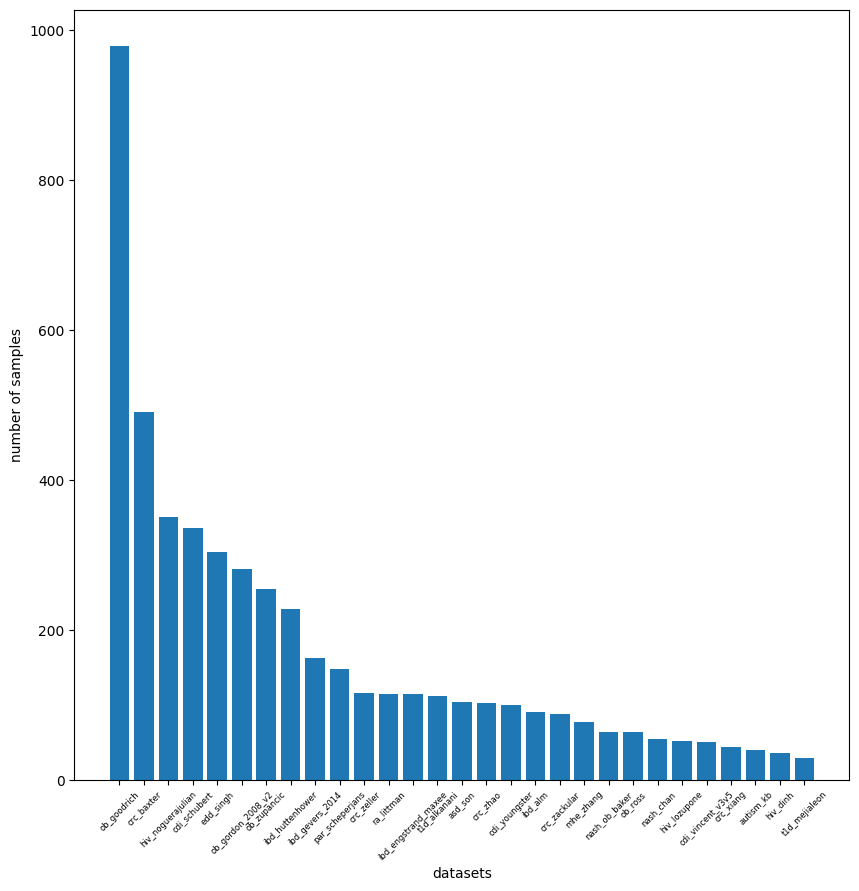

In [54]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(np.arange(0, len(dataHD.From.value_counts())), dataHD.From.value_counts())
plt.xticks(np.arange(0, len(dataHD.From.value_counts())), list(dataHD.From.value_counts().keys()), rotation=45, size=6)
plt.xlabel('datasets')
plt.ylabel('number of samples')
plt.show()

PCA/PCoA

In [6]:
def PC(feature_table, pca=True):
    if not pca:
        distance_table = beta_diversity("braycurtis", feature_table, list(feature_table.index))
        components = pcoa(distance_table)
        pcoa_comp = components.samples.loc[:4974, ['PC1','PC2']]
        print("explained variance: ", components.proportion_explained[:2]*100)
        return pcoa_comp
    else:
        pca = PCA(n_components=2)
        pca.fit(feature_table)
        components = pca.transform(feature_table)
        pca_comp = pd.DataFrame(data= components[:4975], columns= ['PC1', 'PC2'])
        loadings = pca.components_[:2].T
        tops = (loadings ** 2).sum(axis=1).argsort()[-10:]
        loadings = loadings[tops]
        print("explained variance: ", pca.explained_variance_ratio_*100)
        return pca_comp, loadings, tops

In [36]:
# components, loadings, tops = PC(all_data.drop(columns=['From']))
components_pcoa = PC(all_data.drop(columns=['From']), pca=False)

c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -51.1470721974508 and the largest is 709.3255088644167.
  warn(


explained variance:  PC1    23.117213
PC2     9.511892
dtype: float64


In [31]:
%matplotlib inline
def plot_pca(components, arrow=True, pca=True, loadings=None, tops=None):
    plt.figure(figsize=(10,10))
    polar_data = dict()
    plt.xlabel('PC1 ', fontsize=20)
    plt.ylabel('PC2 ', fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    arrows, var_x, var_y, angles, sizes = dict(), [], [], [], []
    for target, color in zip(all_names,colors):
        arrows[target] = list()
        indicesToKeep = (dataHD['From'] == target) & (dataHD['State'] == 'H')
        x = components.loc[indicesToKeep.values, 'PC1'].values.mean()
        y = components.loc[indicesToKeep.values, 'PC2'].values.mean()
        arrows[target].append(x)
        arrows[target].append(y)
        if not arrow:
            plt.scatter(components.loc[indicesToKeep.values, 'PC1'] , components.loc[indicesToKeep.values, 'PC2'], c='none', edgecolors=color, s=50)
        
        indicesToKeep = (dataHD['From'] == target) & (dataHD['State'] == 'D')
        x = components.loc[indicesToKeep.values, 'PC1'].values.mean()
        y = components.loc[indicesToKeep.values, 'PC2'].values.mean()
        arrows[target].append(x)
        arrows[target].append(y)
        if not arrow:
            plt.scatter(components.loc[indicesToKeep.values, 'PC1'] , components.loc[indicesToKeep.values, 'PC2'], c=color, edgecolors=color, s=50)
    # find centroids and plotting an arrow

    for (name, (x1,y1,x2,y2)), color in zip(arrows.items(), colors):
        if arrow:
            plt.arrow(x1, y1, x2-x1,y2-y1, color=color_disease[data_map[name]], width = 0.005)
            # plt.arrow(x1, y1, x2-x1,y2-y1, color=color, width = 0.005)     
        angles.append(math.atan2(y2-y1, x2-x1))
        sizes.append(math.sqrt((x2-x1)**2+(y2-y1)**2))
    if arrow:
        plt.legend(all_names, bbox_to_anchor=(1., 0., 0.6, 1.)) 
    else:
        plt.legend(np.repeat(all_names, 2), bbox_to_anchor=(0.7, 0., 0.9, 1.)) 
    # return angles, sizes
    if pca:
        for (i, arrow), index in zip(enumerate(loadings[-5:]),tops):
            plt.arrow(0, 0, *arrow, color='k', alpha=0.5, ec='none',
              length_includes_head=True)
            plt.text(*(arrow * 1.0), all_data.columns[index]+'_'+str(5-i),
             ha='center', va='center')
    return angles, sizes

In [216]:
loadings

array([[-0.01676333, -0.04388736],
       [-0.01499995,  0.04851666],
       [-0.0147108 , -0.05351756],
       [ 0.0254251 , -0.0561601 ],
       [-0.01800484, -0.07073529],
       [-0.00443118, -0.10070268],
       [-0.01190469, -0.12371224],
       [-0.0186518 , -0.14592065],
       [-0.09004902,  0.96154081],
       [ 0.99368312,  0.08088593]])

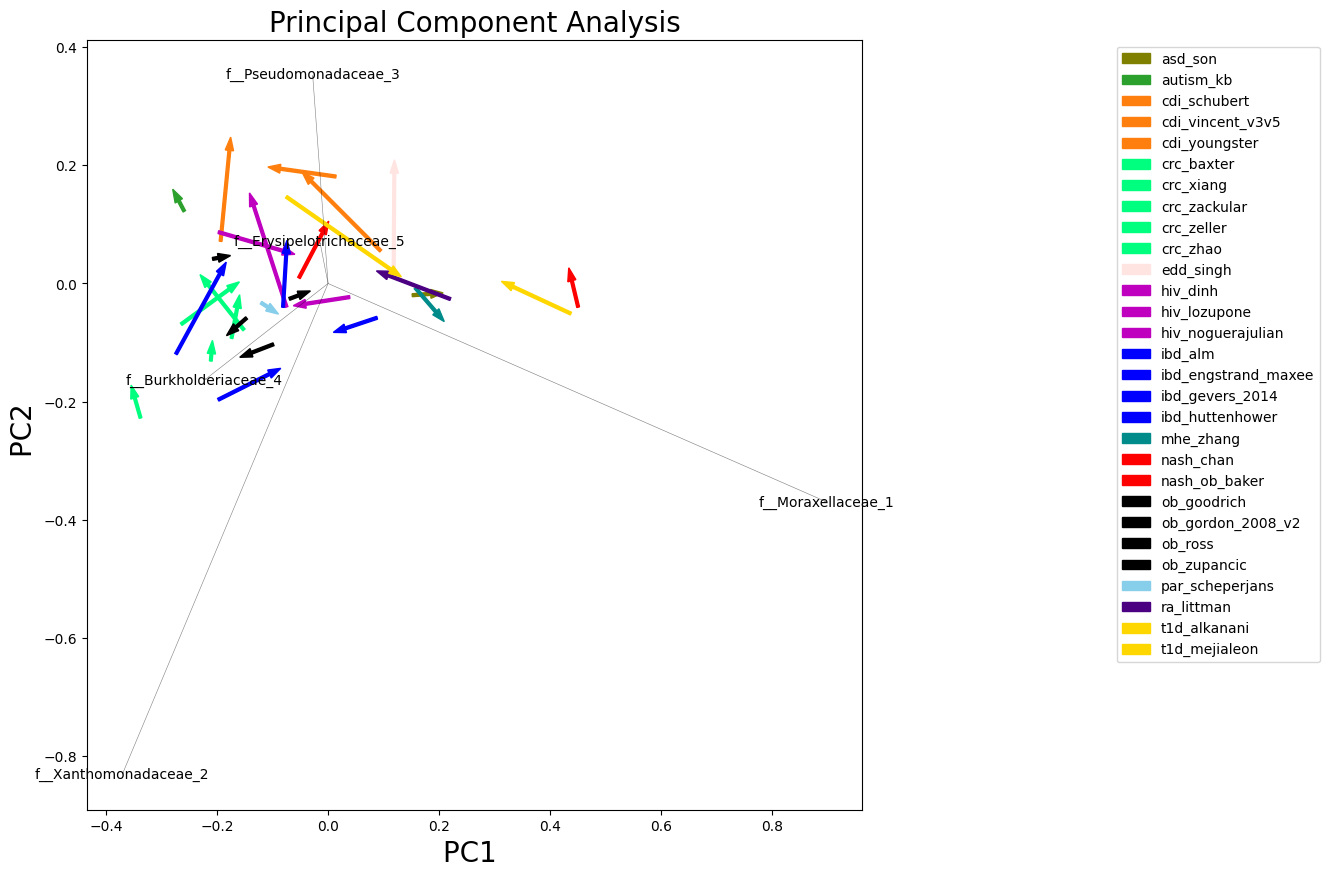

In [56]:
polar_data = plot_pca(components, loadings=loadings, tops=tops)

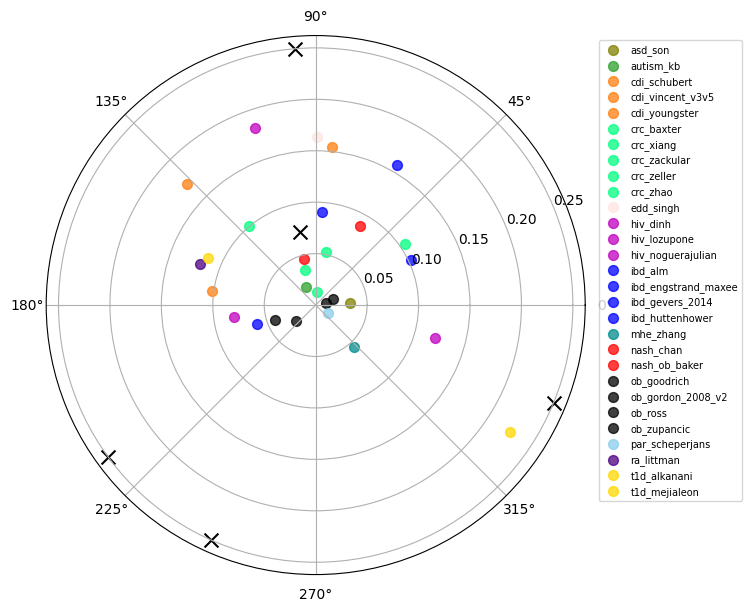

In [57]:
from matplotlib.patches import Ellipse
angles, sizes = polar_data

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size in zip(angles,all_names,sizes):
    # ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    ax.scatter(angle, size, c=color_disease[data_map[name]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
for (i, arrow), index in zip(enumerate(loadings[-5:]),tops):
    ax.scatter(math.atan2(arrow[1], arrow[0]),min(math.sqrt((arrow[0])**2+(arrow[1])**2),0.25),  c='black', alpha=1, marker='x', s=100)
    # ax.text(arrow[0], arrow[1], all_data.columns[index]+'_'+str(i), ha='center', va='center')
plt.legend(all_names,prop={'size': 7}, bbox_to_anchor=(1.3, 1))

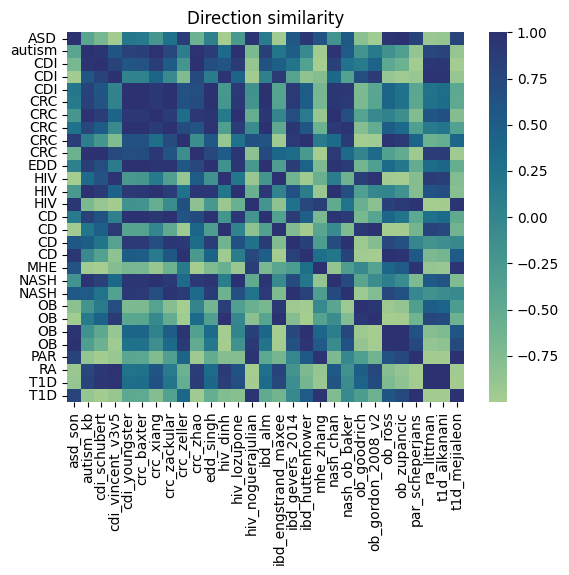

In [58]:
new_df = pd.DataFrame({'angles': angles, 'length': sizes, 'names': np.array(all_names),'disease': np.array([data_map[name] for name in all_names])})
new_df['similarity'] = [np.cos(new_df['angles'][i]- new_df['angles']) for i in range(len(new_df))]
mat = [np.array(np.cos(new_df['angles'][i]-new_df['angles'])) for i in range(len(new_df))]
n = len(mat)
plt.figure()
plt.title('Disease Similarity matrix',fontsize=20)
plt.title('Direction similarity')
plt.xticks(range(n), all_names, rotation=90)
plt.yticks(range(n), all_names)
plot = seaborn.heatmap(mat,xticklabels=all_names, yticklabels=[data_map[name] for name in all_names],cmap="crest")
plt.show()

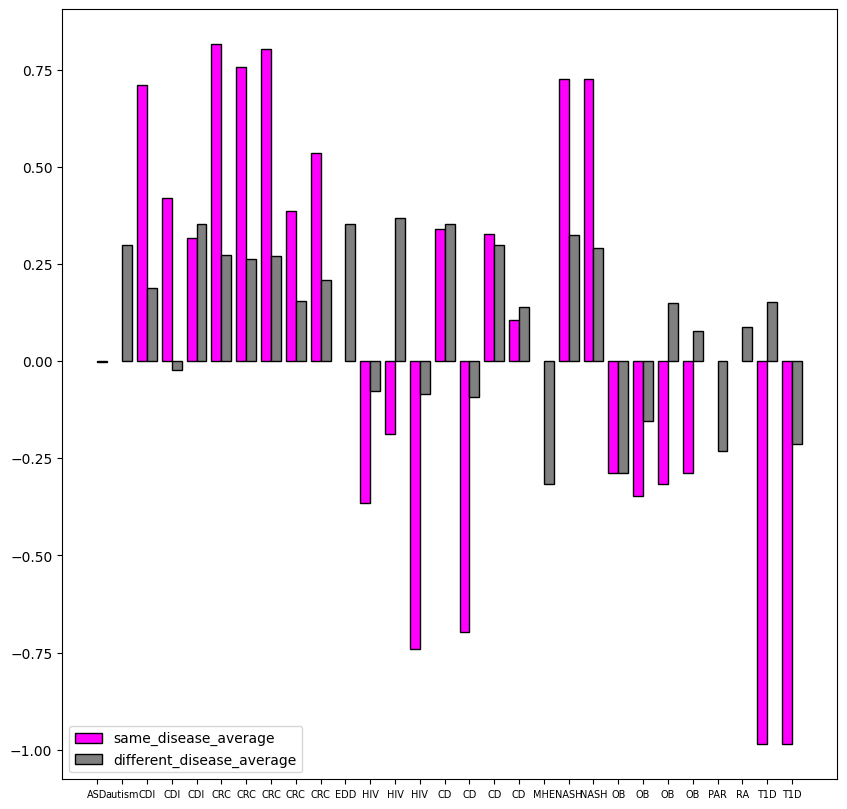

In [59]:
indexes = [i for i in range(29) if i not in [0,1,10, 18, 25, 26]]
new_df.loc[:,'different_disease'] = [sum((new_df['similarity'][i][(new_df['disease'][i] != new_df['disease']) & (new_df['names'][i] != new_df['names'])]))/len(new_df['similarity'][i][(new_df['disease'][i] != new_df['disease']) & (new_df['names'][i] != new_df['names'])]) for i in range(29)]
new_df.loc[indexes,'same_disease'] = [sum((new_df['similarity'][i][(new_df['disease'][i] == new_df['disease']) & (new_df['names'][i] != new_df['names'])]))/len(new_df['similarity'][i][(new_df['disease'][i] == new_df['disease']) & (new_df['names'][i] != new_df['names'])]) for i in indexes]

n= 29
r = np.arange(n)
width = 0.4
  
plt.figure(figsize=(10,10))
plt.bar(r, new_df.loc[:,'same_disease'], color = 'magenta',
        width = width, edgecolor = 'black',
        label='same_disease_average')
plt.bar(r + width, new_df.loc[:, 'different_disease'], color = 'grey',
        width = width, edgecolor = 'black',
        label='different_disease_average')

# plt.grid(linestyle='--')
plt.xticks(r + width/2,new_df.loc[:,'disease'], size=7)
plt.legend()

PCoA

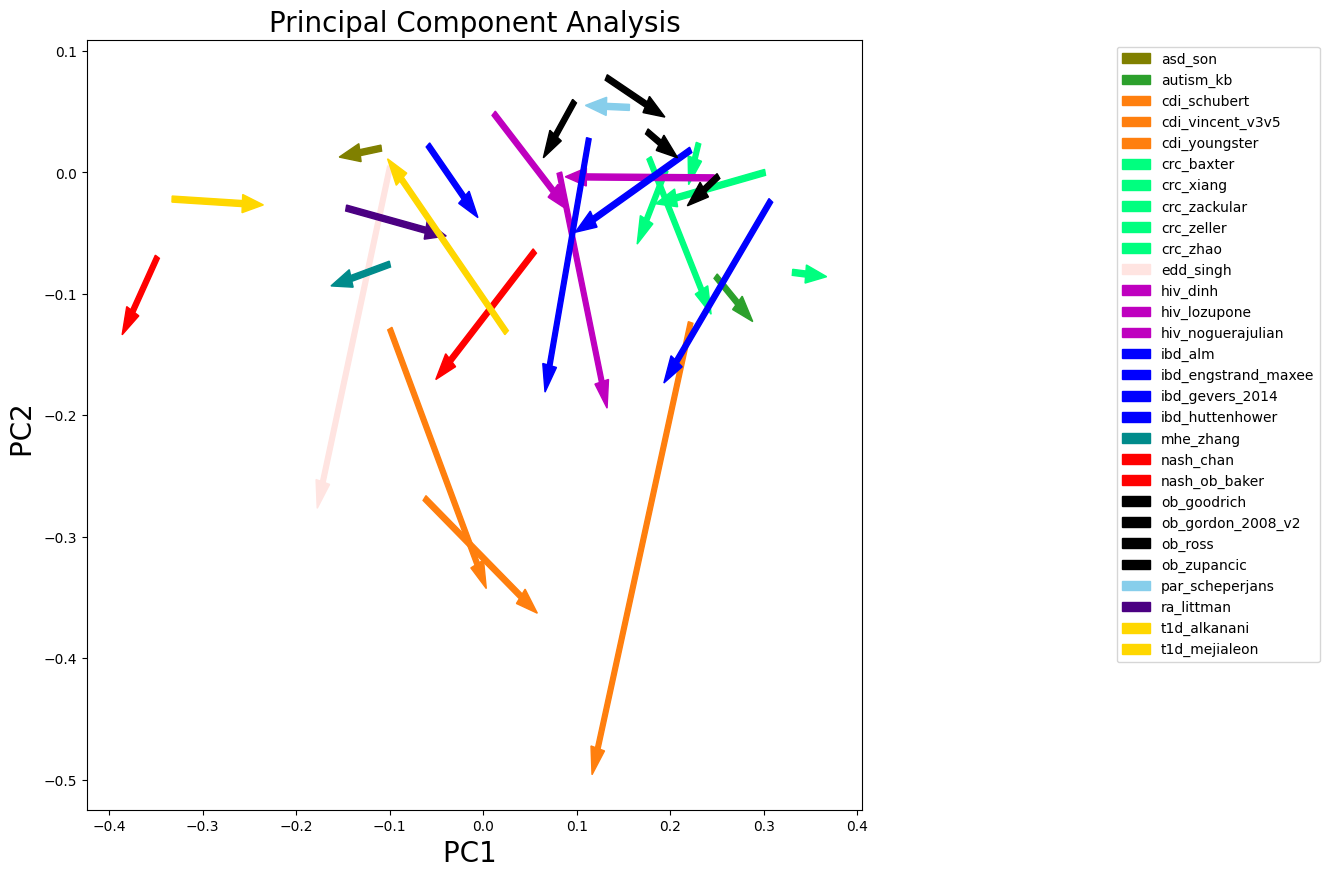

In [60]:
polar_data = plot_pca(components_pcoa, pca=False)

POLAR PLOT

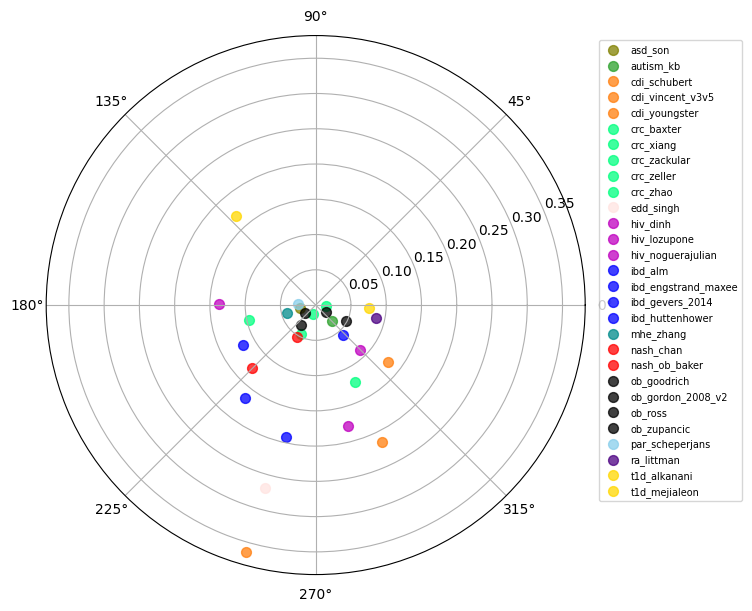

In [61]:
from matplotlib.patches import Ellipse
angles, sizes = polar_data

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size in zip(angles,all_names,sizes):
    # ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax.scatter(angle, size, c=color_disease[data_map[name]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
plt.legend(all_names,prop={'size': 7}, bbox_to_anchor=(1.3, 1))


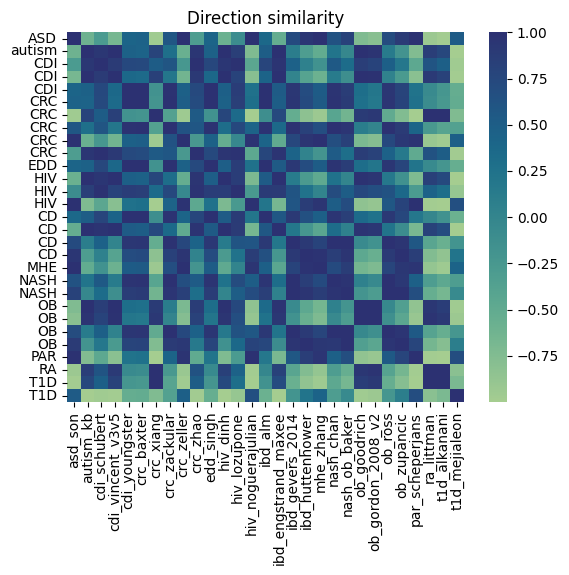

In [62]:
new_df = pd.DataFrame({'angles': angles, 'length': sizes, 'names': np.array(all_names),'disease': np.array([data_map[name] for name in all_names])})
new_df['similarity'] = [np.cos(new_df['angles'][i]- new_df['angles']) for i in range(len(new_df))]
mat = [np.array(np.cos(new_df['angles'][i]-new_df['angles'])) for i in range(len(new_df))]
n = len(mat)
plt.figure()
plt.title('Disease Similarity matrix',fontsize=20)
plt.title('Direction similarity')
plt.xticks(range(n), all_names, rotation=90)
plt.yticks(range(n), all_names)
plot = seaborn.heatmap(mat,xticklabels=all_names, yticklabels=[data_map[name] for name in all_names],cmap="crest")
plt.show()

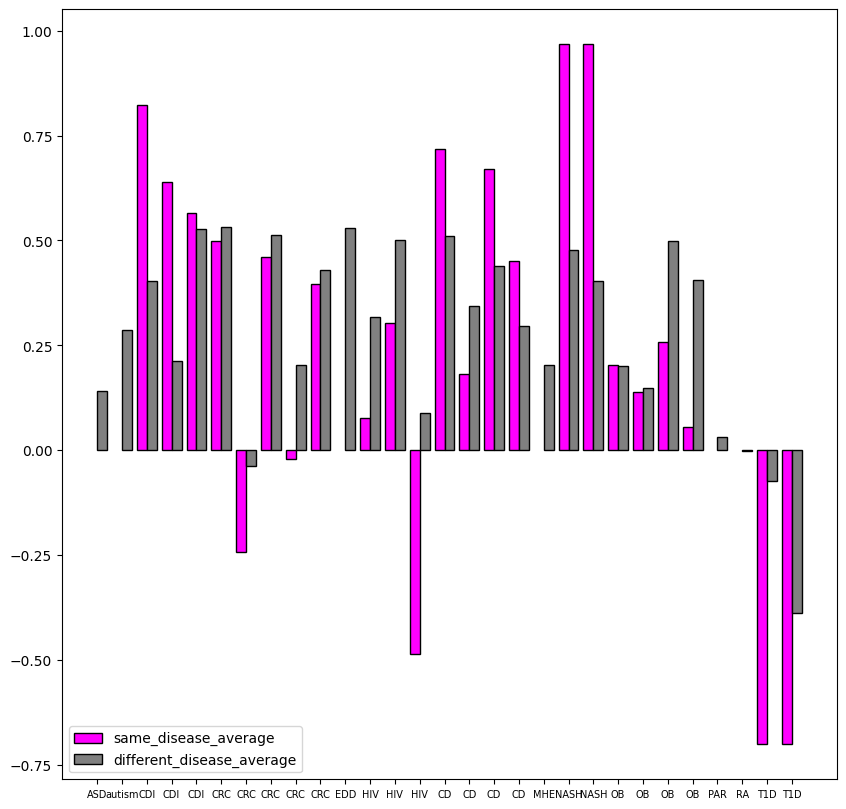

In [63]:
indexes = [i for i in range(29) if i not in [0,1,10, 18, 25, 26]]
new_df.loc[:,'different_disease'] = [sum((new_df['similarity'][i][(new_df['disease'][i] != new_df['disease']) & (new_df['names'][i] != new_df['names'])]))/len(new_df['similarity'][i][(new_df['disease'][i] != new_df['disease']) & (new_df['names'][i] != new_df['names'])]) for i in range(29)]
new_df.loc[indexes,'same_disease'] = [sum((new_df['similarity'][i][(new_df['disease'][i] == new_df['disease']) & (new_df['names'][i] != new_df['names'])]))/len(new_df['similarity'][i][(new_df['disease'][i] == new_df['disease']) & (new_df['names'][i] != new_df['names'])]) for i in indexes]

n= 29
r = np.arange(n)
width = 0.4
  
plt.figure(figsize=(10,10))
plt.bar(r, new_df.loc[:,'same_disease'], color = 'magenta',
        width = width, edgecolor = 'black',
        label='same_disease_average')
plt.bar(r + width, new_df.loc[:, 'different_disease'], color = 'grey',
        width = width, edgecolor = 'black',
        label='different_disease_average')
  
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,new_df.loc[:,'disease'], size=7)
plt.legend()

Leave one out test

PCA- fit both data

PCA- fit only american

PCA- all data vs only american's

In [ ]:
def pca_disease(disease):
    arrows = []
    lst = disease_map[disease] + ['None']*(5-len(disease))
    data_partial = dataHD[(dataHD['From'] == lst[0]) | (dataHD['From'] == lst[1]) | (dataHD['From'] == lst[2]) | (dataHD['From'] == lst[3]) | (dataHD['From'] == lst[4])]
    keep_features = [i for i in data_partial.columns if i in dataAmericans.columns and data_partial[i].sum() > 0.1] 
    print(len(keep_features))  
    data_filtered = data_partial.loc[:,keep_features]
    dataAmericans_filtered = dataAmericans.loc[:,keep_features]     
    pca = PCA(n_components=2)
    pca.fit(pd.concat([dataAmericans_filtered, data_filtered]))
    components_americans = pca.transform(dataAmericans_filtered)
    components_disease = pca.transform(data_filtered)
    print("explained variance: ", sum(pca.explained_variance_ratio_))
    pca_americans = pd.DataFrame(data= components_americans, columns= ['Pc1', 'Pc2'])
    pca_disease = pd.DataFrame(data= components_disease, columns= ['Pc1', 'Pc2'])  
    
    plt.xlabel('Pc1 ', fontsize=10)
    plt.ylabel('Pc2 ', fontsize=10)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = lst
    colors = ['r','c', 'b','lime']
    for target, color in zip(targets,colors):
        indicesToKeep = (data_partial['From'] == target) & (data_partial['State'] == 'H')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c=color, edgecolors=color, s=50)
        indicesToKeep = (data_partial['From'] == target) & (data_partial['State'] == 'D')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c='none', edgecolors=color, s=50)
    
    # find centroids and plotting an arrow
    col = ['r', 'c', 'b', 'lime']
    for j in range(0,len(arrows),4):
        plt.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4], width = 0.01)
    plt.legend(targets) 
    # fig.show() 

                              

In [ ]:
pca_disease("OB")

In [ ]:
data_map

POLAR PLOT

In [ ]:
from matplotlib.patches import Ellipse
# 'skyblue','mistyrose', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'b', 'g']
color_disease = {"CD": 'b', "CDI": '#ff7f0e', "autism": '#2ca02c', "OB": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime', "EDD": 'mistyrose', "PAR": 'skyblue', "NASH": '#d62728', "MHE": y, "ASD":'olive'}
var_x, var_y, angles, sizes = polar_data[0]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size in zip(angles,all_names,sizes):
    # ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax.scatter(angle, size, c=color_disease[data_map[name]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
plt.legend(all_names,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Now only for the microbiomeHD PCA.

In [ ]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.drop(columns=['DiseaseState', 'From', 'State']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)
# plt.xlabel('Pc1 ', fontsize=20)
# plt.ylabel('Pc2 ', fontsize=20)
# plt.title("Principal Component Analysis",fontsize=20)
# targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]

colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['State'] == target[1])
    fill = 'none'
    if target[1] == "D":
        fill = color
    x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # axes[0].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4],width = 0.01)
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

STATISTICS

In [68]:
new_df = pd.DataFrame({'angles': angles, 'length': sizes, 'names': np.array(all_names)})

In [70]:
new_df

,angles,length,names
0,-0.508811,0.038589,asd_son
1,-2.168652,0.047536,autism_kb
2,-2.817729,0.152989,cdi_schubert
3,-3.103501,0.091507,cdi_vincent_v3v5
4,-1.875164,0.081880,cdi_youngster
5,NaN,NaN,crc_baxter
6,-2.518170,0.023848,crc_xiang
7,-2.349800,0.011768,crc_zackular
8,-0.022883,0.058448,crc_zeller
9,3.099615,0.086459,crc_zhao


In [62]:
mat = [np.cos(new_df['angles'][i], new_df['angles']) for i in range(len(new_df))]

C:\Users\talno\AppData\Local\Temp\ipykernel_24856\1254964716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat = [np.cos(new_df['angles'][i], new_df['angles']) for i in range(len(new_df))]


In [76]:
[np.array(np.cos(new_df['angles'][i]-new_df['angles'])) for i in range(len(new_df))]

[array([ 1.        , -0.08892747, -0.67289951, -0.85413957,  0.20302158,
                nan, -0.42463919, -0.26691754,  0.88424216, -0.89299792,
        -0.62374572, -0.36038916, -0.86107569,  0.86435497, -0.55477269,
        -0.65683331,  0.17303168,  0.99875706,  0.87554278, -0.31590495,
         0.80545431, -0.94838399, -0.98339526,  0.89353795,  0.87487165,
         0.88129118, -0.83983894, -0.82996922,  0.7808652 ]),
 array([-0.08892747,  1.        ,  0.7966424 ,  0.59393994,  0.95724068,
                nan,  0.9395378 ,  0.98363752, -0.54381179,  0.52768975,
         0.83399872,  0.96115487,  0.58303555, -0.57775471,  0.87804018,
         0.80945892, -0.99640139, -0.13846258, -0.55908626,  0.97312446,
         0.51868281,  0.40020524,  0.26820847,  0.36774877,  0.40463574,
        -0.54907236,  0.61536976,  0.62940627, -0.69166493]),
 array([-0.67289951,  0.7966424 ,  1.        ,  0.95944416,  0.58771528,
                nan,  0.95546696,  0.89250457, -0.94048308,  0.93382309,


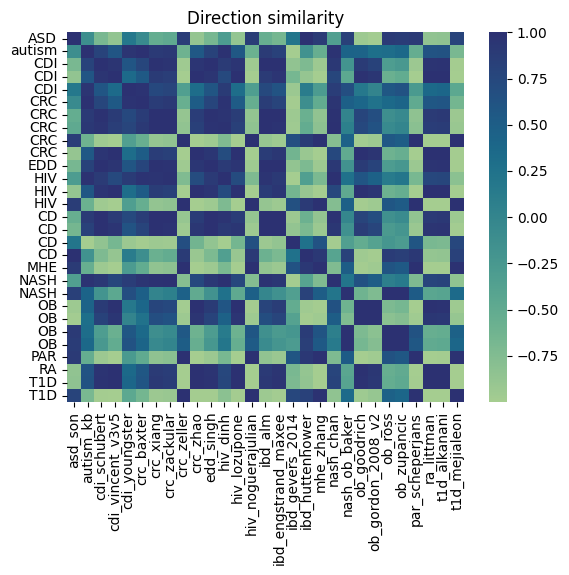

In [146]:
mat = [np.array(np.cos(new_df['angles'][i]-new_df['angles'])) for i in range(len(new_df))]
n = len(mat)
plt.figure()
plt.title('Disease Similarity matrix',fontsize=20)
plt.title('Direction similarity')
plt.xticks(range(n), all_names, rotation=90)
plt.yticks(range(n), all_names)
plot = seaborn.heatmap(mat,xticklabels=all_names, yticklabels=[data_map[name] for name in all_names],cmap="crest")
plt.show()

In [ ]:

new_df['similarity'] = mat
new_df['similarity'] = [np.delete(new_df['similarity'][i], i) for i in range(17)]
new_df['pred'] = [np.delete(np.array((new_df['disease'] == new_df['disease'][i]).values*1),i) for i in range(17)]
indexes = [i for i in range(17) if i not in [7,8,9,14]]
new_df.loc[indexes,'different_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 0]))/len(new_df['similarity'][i][new_df['pred'][i] == 0]) for i in indexes]
new_df.loc[indexes,'same_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 1]))/len(new_df['similarity'][i][new_df['pred'][i] == 1]) for i in indexes]

In [ ]:
new_df.head(3)

In [ ]:
indexes = [i for i in range(17) if i not in [7,8,9,14]]
new_df.loc[indexes,'different_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 0]))/len(new_df['similarity'][i][new_df['pred'][i] == 0]) for i in indexes]
new_df.loc[indexes,'same_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 1]))/len(new_df['similarity'][i][new_df['pred'][i] == 1]) for i in indexes]

n= len(indexes)
r = np.arange(n)
width = 0.4
  
  
plt.bar(r, new_df.loc[indexes,'same_disease'], color = 'magenta',
        width = width, edgecolor = 'black',
        label='same_D_av')
plt.bar(r + width, new_df.loc[indexes, 'different_disease'], color = 'grey',
        width = width, edgecolor = 'black',
        label='Diff_D_av')
  
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,new_df.loc[indexes,'disease'], size=7)
plt.legend()

In [ ]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.query('DiseaseState != 0').drop(columns=['DiseaseState', 'From']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])
pca_HD['Cluster'] = dataHD.query('DiseaseState != 0').DiseaseState

sns.lmplot( x="Pc1", y="Pc2",
data=pca_HD, 
fit_reg=False, 
hue='Cluster', # color by cluster
legend=True,
scatter_kws={"s": 80}) 


In [ ]:
from sklearn.manifold import TSNE
# tsne = TSNE(metric = 'braycurtis', perplexity=30.0)
tsne = TSNE(metric = 'jaccard', perplexity=30.0)
embeddings = tsne.fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
# embeddings = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
pca_HD_e = pd.DataFrame(data = embeddings, columns = ['Pc1', 'Pc2'])

In [ ]:
import sklearn
sorted(sklearn.neighbors.VALID_METRICS['brute'])

In [ ]:

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)

targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
    fill = 'none'
    if target[1] == "D":
        # color = 'r'
        fill = color
    # else:
        # color = 'k'
    x = pca_HD_e.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD_e.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD_e.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD_e.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # if target[0] == 'schubert':
    ax1.scatter(pca_HD_e.loc[indicesToKeep.values, 'Pc1'] , pca_HD_e.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)

# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4], width = 0.5)
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    # size = 0.04
    c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=70)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax1.legend(targets,prop={'size': 7}, bbox_to_anchor=(0.7, 1))
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Bray-Curtis: Bray-Curtis is a widely used distance metric in microbiome analysis. It accounts for the relative abundance of taxa and is not affected by differences in overall sequencing depth. It is generally good for comparing community composition across different samples and habitats.

Jaccard: Jaccard is a binary distance metric that only considers the presence or absence of microbial taxa in a community. It is good for comparing the similarity of microbial communities based on their shared taxa.

